In [1]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import category_encoders as ce
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
import joblib

%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
SBA = pd.read_csv('/content/SBA_loans_small.csv')
SBA.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,MIS_Status,GrAppv,SBA_Appv
0,BOULDER,CO,80302,WELLS FARGO BANK NATL ASSOC,SD,327122,39,8,1.0,0,8,1,1,Y,N,"$60,639.00",$0.00,CHGOFF,"$30,000.00","$15,000.00"
1,SEATTLE,WA,98101,HANMI BANK,CA,722211,15,2,1.0,0,2,1,1,0,N,"$66,000.00",$0.00,CHGOFF,"$66,000.00","$33,000.00"
2,PHOENIX,AZ,85023,CAPITAL ONE NATL ASSOC,VA,323119,62,15,1.0,0,0,1,1,N,N,"$50,000.00",$0.00,CHGOFF,"$50,000.00","$25,000.00"
3,HOUSTON,TX,77074,JPMORGAN CHASE BANK NATL ASSOC,IL,524210,66,3,1.0,1,3,0,1,Y,N,"$168,853.00",$0.00,CHGOFF,"$50,000.00","$25,000.00"
4,LAS CRUCES,NM,88001,BANK OF AMERICA NATL ASSOC,NM,0,60,1,2.0,0,0,0,0,N,N,"$26,000.00",$0.00,CHGOFF,"$26,000.00","$23,400.00"


In [6]:
SBA.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross',
       'MIS_Status', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [7]:
SBA.shape

(448583, 20)

With the given dataset, we have around 800255 rows and 20 columns of SBA Loan historical data.

And the columns are

1. City : Borrower City
2. State : Borrower State
3. Zip : Borrower Zip Code
4. Bank : Bank Name
5. BankState : Bank State
6. NAICS : North American industry classification system code.
7. NoEmp : Number of Business Employees
8. NewExist : 1 = Existing business, 2 = New business
9. CreateJob : Number of Jobs Created
10. RetainedJob : Number of jobs retained
11. FranchiseCode : Franchise code, (00000 or 00001) = No franchise
12. UrbanRural : 1 = Urban, 2 = rural, 0 = undefined
13. RevLineCr : Revolving line of credit: Y = Yes, N = No
14. LowDoc : LowDoc Loan Program: Y = Yes, N = No
15. DisbursementGross : Amount disbursed
16. BalanceGross : Gross amount outstanding
17. GrAppv : Gross amount of loan approved by bank
18. SBA_Appv : SBA's guaranteed amount of approved loan
19. MIS_Status: Target Column showing defaulted and Paid loans
20. Index: showing indexes


# EDA
 In this step we will analyze all the feature from SBA Dataset.

First of all lets split our data for training and testing this testing data we will use in scoring function

In [8]:
X = SBA.drop('MIS_Status', axis=1)
y = SBA['MIS_Status']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# X_test.to_csv('X_test.csv', index=False)

Now I will combine X_train and y_train for furter analysis

In [11]:
SBA = pd.concat([X_train, y_train], axis=1)

In [12]:
SBA

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
163212,HOPKINS,MI,49328,UNITED BANK OF MICHIGAN,MI,0,180,1,1.0,0,0,1,0,N,Y,"$60,000.00",$0.00,"$60,000.00","$52,680.00",P I F
283960,PITTSBURGH,PA,15212,CITIZENS BANK NATL ASSOC,MA,454210,84,3,1.0,0,3,1,1,Y,N,"$22,895.00",$0.00,"$5,000.00","$2,500.00",P I F
434374,AKRON,OH,44306,"FIRSTMERIT BANK, N.A.",OH,0,90,5,2.0,0,0,1,0,N,Y,"$100,000.00",$0.00,"$100,000.00","$80,000.00",P I F
134851,EL DORADO,KS,67042,INTRUST BANK NATL ASSOC,KS,0,60,1,2.0,0,0,1,0,0,Y,"$26,300.00",$0.00,"$40,500.00","$32,400.00",P I F
117072,OAKLAND,CA,94612,BANK OF AMERICA NATL ASSOC,NC,453998,84,6,1.0,0,6,0,1,Y,N,"$130,500.00",$0.00,"$60,000.00","$30,000.00",P I F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,BEAVER FALLS,PA,15010,FIRST COMMONWEALTH BANK,PA,541430,144,2,2.0,6,2,3512,1,0,N,"$130,000.00",$0.00,"$130,000.00","$110,500.00",P I F
365838,NORTH SALT LAKE,UT,84054,JPMORGAN CHASE BANK NATL ASSOC,IL,323110,84,2,1.0,0,2,1,1,Y,N,"$97,697.00",$0.00,"$25,000.00","$12,500.00",P I F
131932,WEARE,NH,3281,CITIZENS BANK NATL ASSOC,RI,235930,82,6,1.0,0,6,1,1,Y,N,"$147,874.00",$0.00,"$50,000.00","$25,000.00",P I F
146867,MONTICELLO,UT,84535,MOUNTAIN W. SMALL BUS. FINAN,UT,0,240,3,1.0,1,3,1,0,N,N,"$169,000.00",$0.00,"$169,000.00","$169,000.00",P I F


In [13]:
SBA.info()

<class 'pandas.core.frame.DataFrame'>
Index: 358866 entries, 163212 to 121958
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   City               358853 non-null  object 
 1   State              358858 non-null  object 
 2   Zip                358866 non-null  int64  
 3   Bank               358275 non-null  object 
 4   BankState          358271 non-null  object 
 5   NAICS              358866 non-null  int64  
 6   Term               358866 non-null  int64  
 7   NoEmp              358866 non-null  int64  
 8   NewExist           358815 non-null  float64
 9   CreateJob          358866 non-null  int64  
 10  RetainedJob        358866 non-null  int64  
 11  FranchiseCode      358866 non-null  int64  
 12  UrbanRural         358866 non-null  int64  
 13  RevLineCr          356990 non-null  object 
 14  LowDoc             357819 non-null  object 
 15  DisbursementGross  358866 non-null  object 
 16  Ba

In [14]:
SBA.isnull().sum()

City                   13
State                   8
Zip                     0
Bank                  591
BankState             595
NAICS                   0
Term                    0
NoEmp                   0
NewExist               51
CreateJob               0
RetainedJob             0
FranchiseCode           0
UrbanRural              0
RevLineCr            1876
LowDoc               1047
DisbursementGross       0
BalanceGross            0
GrAppv                  0
SBA_Appv                0
MIS_Status              0
dtype: int64

Let's start by removing records from some of these columns with null values.
Decided to remove the rows entirely rather than imputing because we have a good number of records to work with, and it's hard to know what would be the best imputing method would be given the nature of the information.

In [15]:
# Drop null values from specified columns
SBA.dropna(subset=['City', 'State', 'BankState','NewExist', 'RevLineCr', 'LowDoc'], inplace=True)
SBA.isnull().sum()

City                 0
State                0
Zip                  0
Bank                 0
BankState            0
NAICS                0
Term                 0
NoEmp                0
NewExist             0
CreateJob            0
RetainedJob          0
FranchiseCode        0
UrbanRural           0
RevLineCr            0
LowDoc               0
DisbursementGross    0
BalanceGross         0
GrAppv               0
SBA_Appv             0
MIS_Status           0
dtype: int64

In [16]:
SBA.dtypes

City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
DisbursementGross     object
BalanceGross          object
GrAppv                object
SBA_Appv              object
MIS_Status            object
dtype: object

The amount of dollars are already in float so there is no need to change them.

In [17]:
SBA.describe()

,Zip,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural
count,355283.000000,355283.000000,355283.000000,355283.000000,355283.00000,355283.000000,355283.000000,355283.000000,355283.000000
mean,53807.857601,399303.995193,110.837774,11.292722,1.28036,8.787825,11.118902,2770.312416,0.760805
std,31220.689775,263175.434233,78.964613,73.387575,0.45180,243.331291,243.405674,12806.117125,0.646448
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,27542.000000,235210.000000,60.000000,2.000000,1.00000,0.000000,0.000000,1.000000,0.000000
50%,55409.000000,445310.000000,84.000000,4.000000,1.00000,0.000000,1.000000,1.000000,1.000000
75%,83709.000000,561740.000000,120.000000,10.000000,2.00000,1.000000,4.000000,1.000000,1.000000
max,99999.000000,928120.000000,569.000000,9999.000000,2.00000,8800.000000,8800.000000,92006.000000,2.000000


In [18]:
SBA.columns

Index(['City', 'State', 'Zip', 'Bank', 'BankState', 'NAICS', 'Term', 'NoEmp',
       'NewExist', 'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural',
       'RevLineCr', 'LowDoc', 'DisbursementGross', 'BalanceGross', 'GrAppv',
       'SBA_Appv', 'MIS_Status'],
      dtype='object')

In [19]:
SBA.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
163212,HOPKINS,MI,49328,UNITED BANK OF MICHIGAN,MI,0,180,1,1.0,0,0,1,0,N,Y,"$60,000.00",$0.00,"$60,000.00","$52,680.00",P I F
283960,PITTSBURGH,PA,15212,CITIZENS BANK NATL ASSOC,MA,454210,84,3,1.0,0,3,1,1,Y,N,"$22,895.00",$0.00,"$5,000.00","$2,500.00",P I F
434374,AKRON,OH,44306,"FIRSTMERIT BANK, N.A.",OH,0,90,5,2.0,0,0,1,0,N,Y,"$100,000.00",$0.00,"$100,000.00","$80,000.00",P I F
134851,EL DORADO,KS,67042,INTRUST BANK NATL ASSOC,KS,0,60,1,2.0,0,0,1,0,0,Y,"$26,300.00",$0.00,"$40,500.00","$32,400.00",P I F
117072,OAKLAND,CA,94612,BANK OF AMERICA NATL ASSOC,NC,453998,84,6,1.0,0,6,0,1,Y,N,"$130,500.00",$0.00,"$60,000.00","$30,000.00",P I F


Now want to address the NAICS codes next. The first two digits of NAICS explained the type of business industries.
NAICS itself has the potential for decision making. The type of industry will affect the company's performance in business. So that this feature will be used later in the model.

In [20]:
def outliers(DataFrame,Series):
    iqr = Series.quantile(.75) - Series.quantile(.25)
    lower_bound = Series.quantile(.25) - (1.5*iqr)
    upper_bound = Series.quantile(.75) + (1.5*iqr)
    return DataFrame[(Series >= upper_bound) | (Series <= lower_bound)]

In [21]:

# Percentage of outliers in NoEmp Feature
print(f'Percentage of outliers: {round(len(outliers(SBA,SBA.NoEmp))/len(SBA.NoEmp)*100,2)}%')

Percentage of outliers: 11.36%


In [22]:
# Encoding the target values
SBA['MIS_Status'] = SBA['MIS_Status'].replace({'CHGOFF': 1, 'P I F': 0})

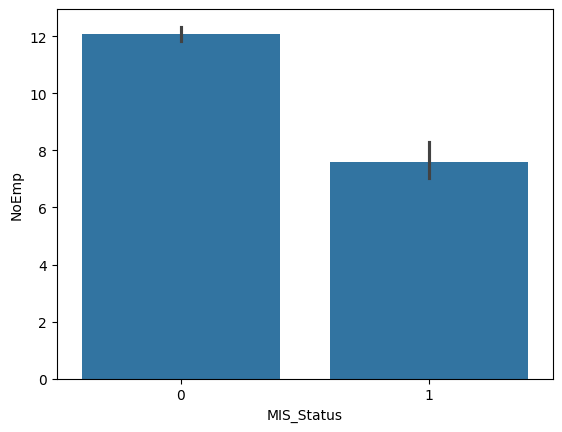

In [23]:
sns.barplot(x=SBA.MIS_Status, y=SBA['NoEmp'])
plt.show()

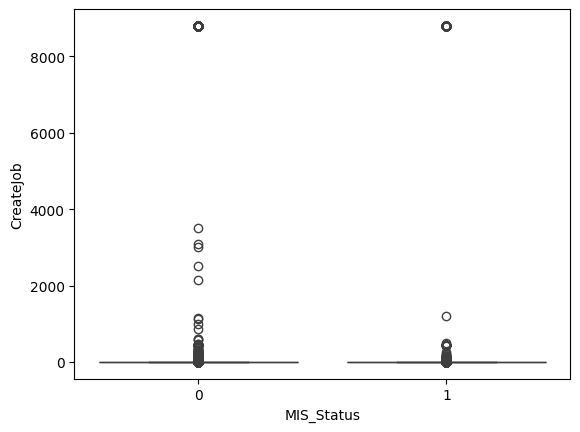

In [24]:
sns.boxplot(x= SBA['MIS_Status'],y=SBA['CreateJob'])
plt.show()

In [25]:
# Percentage of outliers in NoEmp CreateJob Feature
print(f'Percentage of outliers: {round(len(outliers(SBA,SBA.CreateJob))/len(SBA.CreateJob)*100,2)}%')

Percentage of outliers: 16.53%


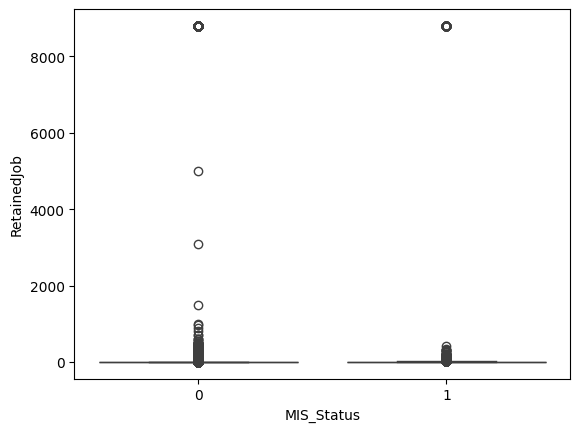

In [26]:
sns.boxplot(x= SBA['MIS_Status'],y=SBA['RetainedJob'])
plt.show()

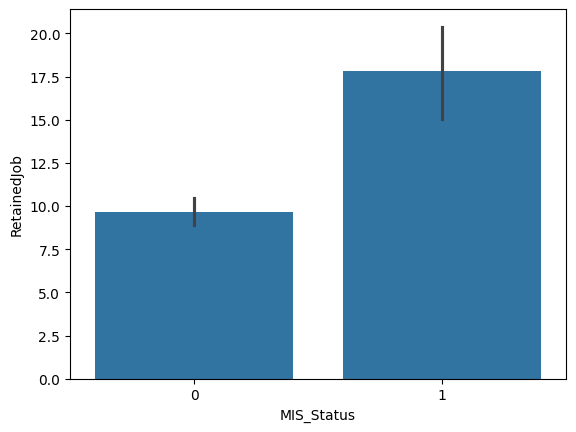

In [27]:
sns.barplot(x=SBA.MIS_Status,y=SBA.RetainedJob)
plt.show()

In [28]:
# Percentage of outliers in RetainedJob Feature
print(f'Percentage of outliers: {round(len(outliers(SBA,SBA.RetainedJob))/len(SBA.RetainedJob)*100,2)}%')

Percentage of outliers: 11.82%


In [29]:
SBA[['MIS_Status','NoEmp','CreateJob','RetainedJob']].corr()

,MIS_Status,NoEmp,CreateJob,RetainedJob
MIS_Status,1.000000,-0.023257,0.012212,0.012728
NoEmp,-0.023257,1.000000,0.010208,0.012802
CreateJob,0.012212,0.010208,1.000000,0.996760
RetainedJob,0.012728,0.012802,0.996760,1.000000


By looking at the correlation between default and the number of jobs created, the NoEmp, CreateJob and RetainedJob are not that much correlated to the target column.

In [30]:
SBA.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
163212,HOPKINS,MI,49328,UNITED BANK OF MICHIGAN,MI,0,180,1,1.0,0,0,1,0,N,Y,"$60,000.00",$0.00,"$60,000.00","$52,680.00",0
283960,PITTSBURGH,PA,15212,CITIZENS BANK NATL ASSOC,MA,454210,84,3,1.0,0,3,1,1,Y,N,"$22,895.00",$0.00,"$5,000.00","$2,500.00",0
434374,AKRON,OH,44306,"FIRSTMERIT BANK, N.A.",OH,0,90,5,2.0,0,0,1,0,N,Y,"$100,000.00",$0.00,"$100,000.00","$80,000.00",0
134851,EL DORADO,KS,67042,INTRUST BANK NATL ASSOC,KS,0,60,1,2.0,0,0,1,0,0,Y,"$26,300.00",$0.00,"$40,500.00","$32,400.00",0
117072,OAKLAND,CA,94612,BANK OF AMERICA NATL ASSOC,NC,453998,84,6,1.0,0,6,0,1,Y,N,"$130,500.00",$0.00,"$60,000.00","$30,000.00",0


Now want to check the business conditions, is it a new or existing business.

In [31]:
SBA.NewExist.unique()

array([1., 2., 0.])

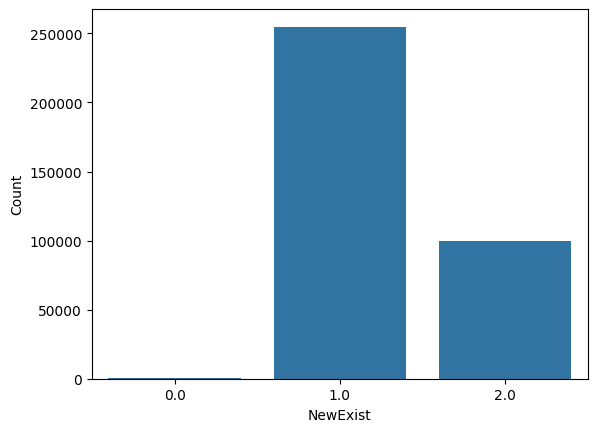

In [32]:
sns.countplot(data=SBA, x='NewExist')
plt.xlabel('NewExist')
plt.ylabel('Count')
plt.show()

There are two features for loan transaction:

RevLineCr : Revolving line of credit which means that if the loan has been paid, the borrower can be able to immediately borrow again.

LowDoc : LowDoc Loan Program means the borrower can borrow with little administration.
The loan transaction type will affects the level of risk and financial psychology. Then this feature will be used as consideration in the approval model.

The features like
DisbursementGross,
BalanceGross,
GrAppv and,
SBA_Appv
Since DisbursementGross, BalanceGross only explain the balance of the loan and not used for loan approval, so the feature can be ignored.

In [33]:
SBA.head()

,City,State,Zip,Bank,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,GrAppv,SBA_Appv,MIS_Status
163212,HOPKINS,MI,49328,UNITED BANK OF MICHIGAN,MI,0,180,1,1.0,0,0,1,0,N,Y,"$60,000.00",$0.00,"$60,000.00","$52,680.00",0
283960,PITTSBURGH,PA,15212,CITIZENS BANK NATL ASSOC,MA,454210,84,3,1.0,0,3,1,1,Y,N,"$22,895.00",$0.00,"$5,000.00","$2,500.00",0
434374,AKRON,OH,44306,"FIRSTMERIT BANK, N.A.",OH,0,90,5,2.0,0,0,1,0,N,Y,"$100,000.00",$0.00,"$100,000.00","$80,000.00",0
134851,EL DORADO,KS,67042,INTRUST BANK NATL ASSOC,KS,0,60,1,2.0,0,0,1,0,0,Y,"$26,300.00",$0.00,"$40,500.00","$32,400.00",0
117072,OAKLAND,CA,94612,BANK OF AMERICA NATL ASSOC,NC,453998,84,6,1.0,0,6,0,1,Y,N,"$130,500.00",$0.00,"$60,000.00","$30,000.00",0


In [34]:
# Drop features of less importance.
data = SBA.drop(['State','City', 'Zip','Bank','BankState','NoEmp','CreateJob','RetainedJob','FranchiseCode','BalanceGross','UrbanRural'], axis=1)

We need to make sure all samples have six digits NAICS code, so the data that don't have any NAICS code can be dropped.

In [35]:
data.head()

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status
163212,0,180,1.0,N,Y,"$60,000.00","$60,000.00","$52,680.00",0
283960,454210,84,1.0,Y,N,"$22,895.00","$5,000.00","$2,500.00",0
434374,0,90,2.0,N,Y,"$100,000.00","$100,000.00","$80,000.00",0
134851,0,60,2.0,0,Y,"$26,300.00","$40,500.00","$32,400.00",0
117072,453998,84,1.0,Y,N,"$130,500.00","$60,000.00","$30,000.00",0


In [36]:
data.MIS_Status.value_counts()

MIS_Status
0    292747
1     62536
Name: count, dtype: int64

In [37]:
for x in data[['NAICS','NewExist', 'RevLineCr','LowDoc','MIS_Status']].columns:
    print(f'{x}: \n{data[x].unique()}\n')

NAICS: 
[     0 454210 453998 ... 325920 624221 315992]

NewExist: 
[1. 2. 0.]

RevLineCr: 
['N' 'Y' '0' 'T' '.' '1' 'R' '`' '2' '3' 'C' '7']

LowDoc: 
['Y' 'N' 'C' 'A' 'S' '0' 'R' '1']

MIS_Status: 
[0 1]



In [38]:
data.NAICS.describe()

count    355283.000000
mean     399303.995193
std      263175.434233
min           0.000000
25%      235210.000000
50%      445310.000000
75%      561740.000000
max      928120.000000
Name: NAICS, dtype: float64

We need to make sure all samples have six digits NAICS code, so the data that don't have any NAICS code can be drop.

In [39]:
data[data['NAICS']==0]

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status
163212,0,180,1.0,N,Y,"$60,000.00","$60,000.00","$52,680.00",0
434374,0,90,2.0,N,Y,"$100,000.00","$100,000.00","$80,000.00",0
134851,0,60,2.0,0,Y,"$26,300.00","$40,500.00","$32,400.00",0
285645,0,60,1.0,N,Y,"$25,000.00","$25,000.00","$22,500.00",0
87481,0,180,1.0,N,N,"$650,000.00","$650,000.00","$521,300.00",0
...,...,...,...,...,...,...,...,...,...
214176,0,66,2.0,N,Y,"$50,000.00","$50,000.00","$40,000.00",0
103355,0,240,1.0,N,N,"$502,000.00","$502,000.00","$502,000.00",0
252709,0,60,1.0,N,N,"$200,000.00","$200,000.00","$150,000.00",0
388468,0,84,2.0,N,Y,"$100,000.00","$100,000.00","$80,000.00",0


In [40]:
data.NAICS
NAICSTrue = 0
NAICSFalse = 0
for i in data.NAICS.astype(str):
    if len(i) == 6:
        NAICSTrue += 1
    else:
        NAICSFalse += 1
print(NAICSTrue)
print(NAICSFalse)

275827
79456


In [41]:
data.head()

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status
163212,0,180,1.0,N,Y,"$60,000.00","$60,000.00","$52,680.00",0
283960,454210,84,1.0,Y,N,"$22,895.00","$5,000.00","$2,500.00",0
434374,0,90,2.0,N,Y,"$100,000.00","$100,000.00","$80,000.00",0
134851,0,60,2.0,0,Y,"$26,300.00","$40,500.00","$32,400.00",0
117072,453998,84,1.0,Y,N,"$130,500.00","$60,000.00","$30,000.00",0


In [42]:
data = data[data.NAICS != 0]

NewExist Feature

We can only classify business with new and existing business. Others data with different code can be ignored

In [43]:
# NewExist
# 1 = Existing Business
# 2 = New Business
data.NewExist.value_counts()

NewExist
1.0    198927
2.0     76595
0.0       305
Name: count, dtype: int64

In [44]:
data = data[(data.NewExist == 1.0) | (data.NewExist == 2.0)]
data.NewExist.value_counts()

NewExist
1.0    198927
2.0     76595
Name: count, dtype: int64

RevLineCr Feature

Since there are only two condition for the revolving credit line, other data must be drop from dataset.

In [45]:
# Revolving line of credit (RevLineCr)
# Y = Yes
# N = No
data.RevLineCr.value_counts()

RevLineCr
N    106602
0     85659
Y     77403
T      5839
R        10
1         5
2         1
C         1
`         1
7         1
Name: count, dtype: int64

In [46]:
data = data[(data.RevLineCr == 'Y') | (data.RevLineCr == 'N')]
data.RevLineCr.value_counts()

RevLineCr
N    106602
Y     77403
Name: count, dtype: int64

LowDoc Feature

Since there are only two condition for the LowDoc condition, other data must be drop from dataset.

In [47]:
# LowDoc Loan Program
# Y = Yes
# N = No
data.LowDoc.value_counts()

LowDoc
N    173264
Y     10008
C       231
S       230
0       213
A        33
R        25
1         1
Name: count, dtype: int64

In [48]:
data = data[(data.LowDoc == 'Y') | (data.LowDoc == 'N')]
data.LowDoc.value_counts()

LowDoc
N    173264
Y     10008
Name: count, dtype: int64

In [49]:
data.head()

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status
283960,454210,84,1.0,Y,N,"$22,895.00","$5,000.00","$2,500.00",0
117072,453998,84,1.0,Y,N,"$130,500.00","$60,000.00","$30,000.00",0
414596,332312,12,1.0,Y,N,"$279,820.00","$150,000.00","$75,000.00",0
366221,621210,96,1.0,N,N,"$130,000.00","$130,000.00","$110,500.00",0
129652,453210,84,1.0,N,N,"$45,000.00","$45,000.00","$22,500.00",0


# 3. Feature Engineering

NAICS

11 : Agriculture, forestry, fishing and hunting

21 : Mining, quarrying, and oil and gas extraction

22 : Utilities

23 : Construction

31-33 : Manufacturing

42 : Wholesale trade

44-45 : Retail trade

48-49 : Transportation and warehousing

51 : Information

52 : Finance and insurance

53 : Real estate and rental and leasing

54 : Professional, scientific, and technical services

55 : Management of companies and enterprises

56 : Administrative/support & waste management/remediation Service

61 : Educational services

62 : Health care and social assistance

71 : Arts, entertainment, and recreation

72 : Accommodation and food services

81 : Other services (except public administration)

92 : Public administration

In [50]:
# Join NAICS with similar industry
def naicsEngineering(x):
    x = str(x)
    x = x[:2]
    if (x == '31') | (x == '32') | (x == '33'):
        x = '31-33'
    elif (x == '44') | (x == '45'):
        x = '44-45'
    elif (x == '48') | (x == '49'):
        x = '48-49'
    return x

In [51]:
data.NAICS = data.NAICS.apply(naicsEngineering)

In [52]:
data

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status
283960,44-45,84,1.0,Y,N,"$22,895.00","$5,000.00","$2,500.00",0
117072,44-45,84,1.0,Y,N,"$130,500.00","$60,000.00","$30,000.00",0
414596,31-33,12,1.0,Y,N,"$279,820.00","$150,000.00","$75,000.00",0
366221,62,96,1.0,N,N,"$130,000.00","$130,000.00","$110,500.00",0
129652,44-45,84,1.0,N,N,"$45,000.00","$45,000.00","$22,500.00",0
...,...,...,...,...,...,...,...,...,...
54886,81,38,1.0,Y,N,"$126,414.00","$50,000.00","$25,000.00",1
207892,48-49,24,2.0,Y,N,"$10,000.00","$10,000.00","$5,000.00",0
110268,42,120,1.0,N,N,"$2,190,000.00","$2,190,000.00","$1,642,500.00",0
365838,31-33,84,1.0,Y,N,"$97,697.00","$25,000.00","$12,500.00",0


Create new column called SBA_AppvPct field since the guaranteed amount is based on a percentage of the gross loan amount rather than dollar amount in most situations

In [54]:
# Convert currency columns from string to numeric (removing $ and ,)
data['DisbursementGross'] = data['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
data['GrAppv'] = data['GrAppv'].replace('[\$,]', '', regex=True).astype(float)
data['SBA_Appv'] = data['SBA_Appv'].replace('[\$,]', '', regex=True).astype(float)

In [55]:
data['SBA_AppvPct'] = data['SBA_Appv']/data['GrAppv']

I wanted to look at whether the loan amount disbursed was equal to the full amount approved, so I added that feature as well.

Createing a column AppvDisbursed flag field signifying if the loan amount disbursed was equal to the full amount approved

In [56]:
data['AppvDisbursed'] = np.where(data['DisbursementGross'] == data['GrAppv'], 1, 0)

Creating a flag to signify if a larger amount was disbursed than what the Bank had approved

In [57]:
data['DisbursedGreaterAppv'] = np.where(data['DisbursementGross'] > data['GrAppv'], 1, 0)

In [58]:
data

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,SBA_AppvPct,AppvDisbursed,DisbursedGreaterAppv
283960,44-45,84,1.0,Y,N,22895.0,5000.0,2500.0,0,0.50,0,1
117072,44-45,84,1.0,Y,N,130500.0,60000.0,30000.0,0,0.50,0,1
414596,31-33,12,1.0,Y,N,279820.0,150000.0,75000.0,0,0.50,0,1
366221,62,96,1.0,N,N,130000.0,130000.0,110500.0,0,0.85,1,0
129652,44-45,84,1.0,N,N,45000.0,45000.0,22500.0,0,0.50,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
54886,81,38,1.0,Y,N,126414.0,50000.0,25000.0,1,0.50,0,1
207892,48-49,24,2.0,Y,N,10000.0,10000.0,5000.0,0,0.50,1,0
110268,42,120,1.0,N,N,2190000.0,2190000.0,1642500.0,0,0.75,1,0
365838,31-33,84,1.0,Y,N,97697.0,25000.0,12500.0,0,0.50,0,1


Now lets check NAICS variable

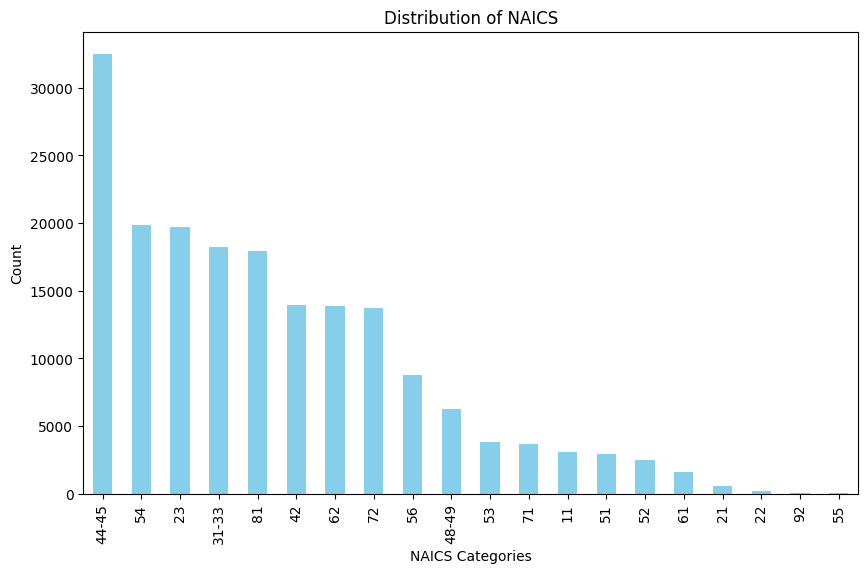

In [59]:
import matplotlib.pyplot as plt

# Assuming data is your DataFrame
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
data['NAICS'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of NAICS')
plt.xlabel('NAICS Categories')
plt.ylabel('Count')
plt.show()

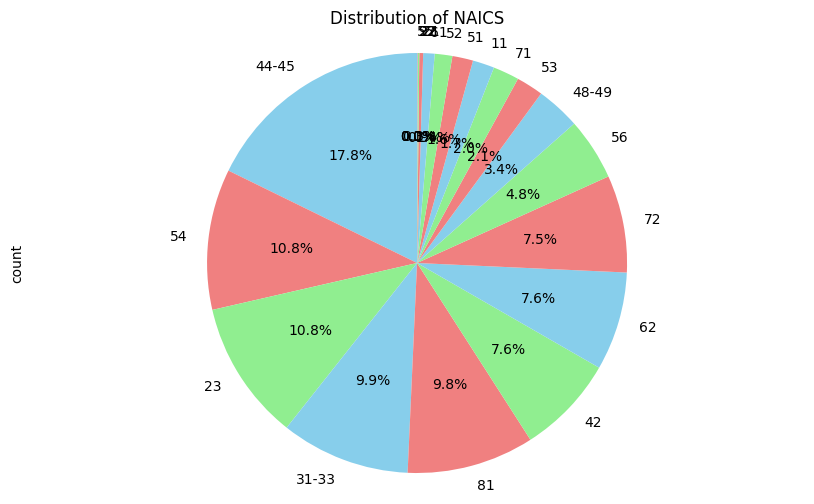

In [60]:
plt.figure(figsize=(10, 6))
data['NAICS'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Distribution of NAICS')
plt.axis('equal')
plt.show()


From these figures we can conclude that most borrowers come from the retail trade industry with around 17.7% from all borrowers.

Now lets check industrywise how many cases are defaulter cases

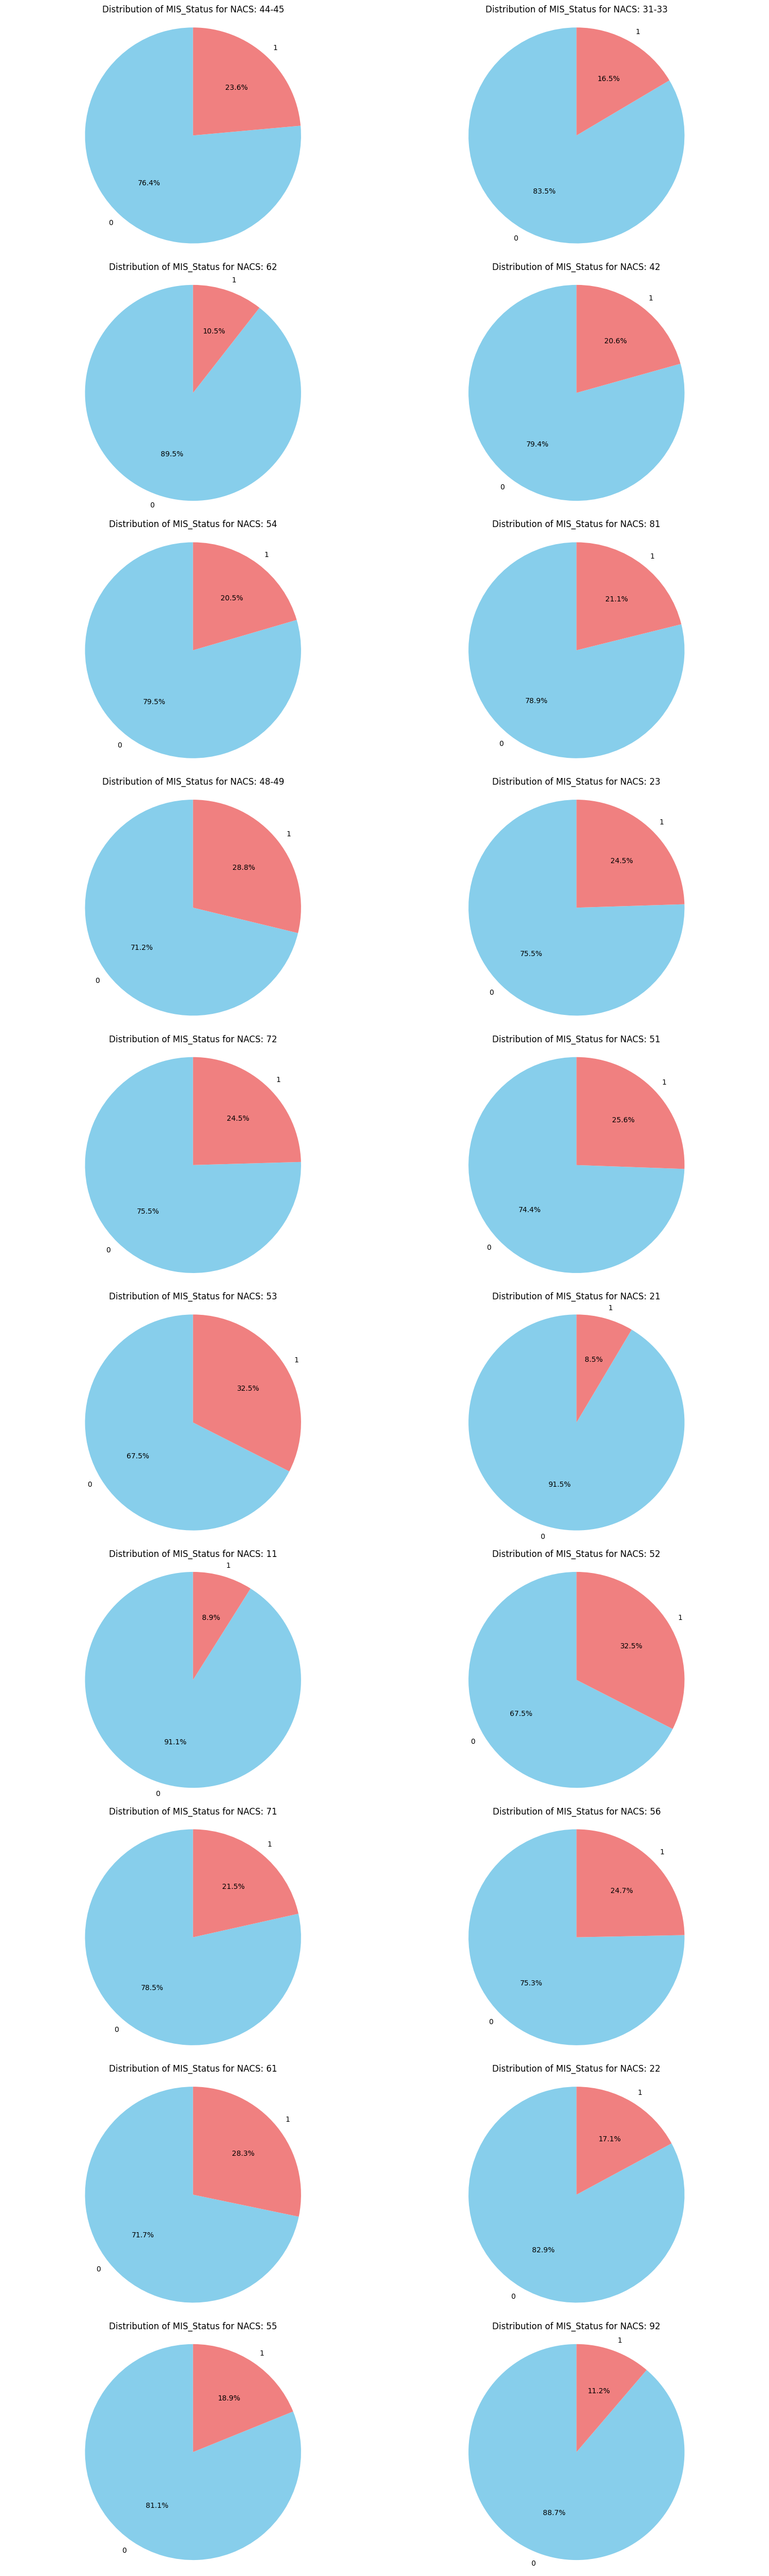

In [61]:
categories = data['NAICS'].unique()
num_categories = len(categories)

plt.figure(figsize=(15, 5 * (num_categories // 2 + num_categories % 2)))

for i, category in enumerate(categories, 1):
    plt.subplot(num_categories // 2 + num_categories % 2, 2, i)
    subset = data[data['NAICS'] == category]
    status_counts = subset['MIS_Status'].value_counts()

    plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
    plt.title(f'Distribution of MIS_Status for NACS: {category}')
    plt.axis('equal')

plt.tight_layout()
plt.show()



From here we can see that different industries have different risk some have less than 10 which is good and some gave greater than 30 percent too.

Now lets check which company has highest gross amount of loan

<ipython-input-62-f523d6dc4132>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_loan_by_industry.index, y=mean_loan_by_industry.values, palette='viridis')


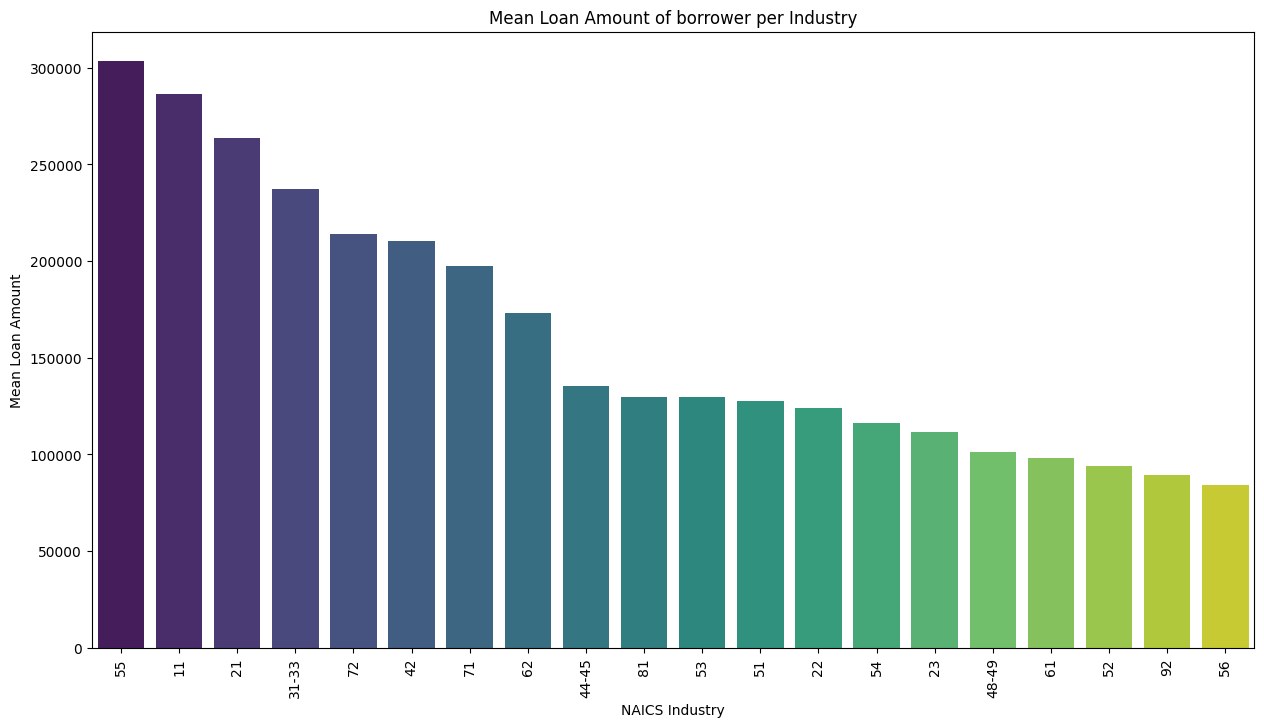

In [62]:
plt.figure(figsize=(15, 8))
mean_loan_by_industry = data.groupby('NAICS')['GrAppv'].mean().sort_values(ascending=False)

sns.barplot(x=mean_loan_by_industry.index, y=mean_loan_by_industry.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Mean Loan Amount of borrower per Industry')
plt.xlabel('NAICS Industry')
plt.ylabel('Mean Loan Amount')
plt.show()


It is showing that Agriculture, forestry, fishing and hunting has the highest average capital

In [63]:
data.head()

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,MIS_Status,SBA_AppvPct,AppvDisbursed,DisbursedGreaterAppv
283960,44-45,84,1.0,Y,N,22895.0,5000.0,2500.0,0,0.50,0,1
117072,44-45,84,1.0,Y,N,130500.0,60000.0,30000.0,0,0.50,0,1
414596,31-33,12,1.0,Y,N,279820.0,150000.0,75000.0,0,0.50,0,1
366221,62,96,1.0,N,N,130000.0,130000.0,110500.0,0,0.85,1,0
129652,44-45,84,1.0,N,N,45000.0,45000.0,22500.0,0,0.50,1,0


# Modelling

In [64]:
X = data.drop('MIS_Status', axis=1)
y = data['MIS_Status']

In [65]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Here I first split the data into a training set (70%) and a temporary set (30%). Then, it further splits the temporary set into a validation set (50% of the temporary set) and a test set (50% of the temporary set).

In [66]:
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Train set shape: (146617, 11) (146617,)
Validation set shape: (36655, 11) (36655,)


In [67]:
X_train.head()

,NAICS,Term,NewExist,RevLineCr,LowDoc,DisbursementGross,GrAppv,SBA_Appv,SBA_AppvPct,AppvDisbursed,DisbursedGreaterAppv
277167,44-45,60,1.0,N,N,155300.0,155300.0,125793.0,0.81,1,0
289963,31-33,180,1.0,N,N,328000.0,328000.0,246000.0,0.75,1,0
172462,44-45,60,1.0,N,N,154456.0,154456.0,115842.0,0.75,1,0
394374,44-45,240,2.0,N,N,199000.0,199000.0,199000.0,1.00,1,0
78035,23,24,1.0,Y,N,406069.0,150000.0,75000.0,0.50,0,1


creating some variables

In [68]:
woe_encoder_revlinecr = ce.WOEEncoder(cols=['RevLineCr'])
woe_encoder_lowdoc = ce.WOEEncoder(cols=['LowDoc'])
woe_encoder_NewExist = ce.WOEEncoder(cols=['NewExist'])

In [69]:
y_train

277167    0
289963    0
172462    0
394374    0
78035     1
         ..
95402     0
300153    0
287709    0
135238    0
107461    0
Name: MIS_Status, Length: 146617, dtype: int64

In [70]:
X_train.shape

(146617, 11)

Encoding the required variables in train dataset

In [71]:
NAICS_dummies_Tr = pd.get_dummies(X_train['NAICS'], prefix='NAICS', drop_first=True).astype(int)
RevLineCr_dummies_Tr = pd.get_dummies(X_train['RevLineCr'], prefix='RevLineCr', drop_first=True).astype(int)
LowDoc_dummies_Tr = pd.get_dummies(X_train['LowDoc'], prefix='LowDoc', drop_first=True).astype(int)

In [72]:
X_train = pd.concat([X_train, NAICS_dummies_Tr, RevLineCr_dummies_Tr, LowDoc_dummies_Tr], axis=1)

Similarly doing this for Validation and test

In [73]:
NAICS_dummies_Val = pd.get_dummies(X_val['NAICS'], prefix='NAICS', drop_first=True).astype(int)
RevLineCr_dummies_Val = pd.get_dummies(X_val['RevLineCr'], prefix='RevLineCr', drop_first=True).astype(int)
LowDoc_dummies_Val = pd.get_dummies(X_val['LowDoc'], prefix='LowDoc', drop_first=True).astype(int)

In [74]:
X_val = pd.concat([X_val, NAICS_dummies_Val, RevLineCr_dummies_Val, LowDoc_dummies_Val], axis=1)

In [75]:
X_train.drop(['NAICS', 'RevLineCr', 'LowDoc'], axis=1, inplace=True)
X_val.drop(['NAICS', 'RevLineCr', 'LowDoc'], axis=1, inplace=True)
X_test.drop(['NAICS', 'RevLineCr', 'LowDoc'], axis=1, inplace=True)

In [76]:
X_train.head()

,Term,NewExist,DisbursementGross,GrAppv,SBA_Appv,SBA_AppvPct,AppvDisbursed,DisbursedGreaterAppv,NAICS_21,NAICS_22,NAICS_23,NAICS_31-33,NAICS_42,NAICS_44-45,NAICS_48-49,NAICS_51,NAICS_52,NAICS_53,NAICS_54,NAICS_55,NAICS_56,NAICS_61,NAICS_62,NAICS_71,NAICS_72,NAICS_81,NAICS_92,RevLineCr_Y,LowDoc_Y
277167,60,1.0,155300.0,155300.0,125793.0,0.81,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
289963,180,1.0,328000.0,328000.0,246000.0,0.75,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
172462,60,1.0,154456.0,154456.0,115842.0,0.75,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
394374,240,2.0,199000.0,199000.0,199000.0,1.00,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78035,24,1.0,406069.0,150000.0,75000.0,0.50,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [77]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146617 entries, 277167 to 107461
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Term                  146617 non-null  int64  
 1   NewExist              146617 non-null  float64
 2   DisbursementGross     146617 non-null  float64
 3   GrAppv                146617 non-null  float64
 4   SBA_Appv              146617 non-null  float64
 5   SBA_AppvPct           146617 non-null  float64
 6   AppvDisbursed         146617 non-null  int64  
 7   DisbursedGreaterAppv  146617 non-null  int64  
 8   NAICS_21              146617 non-null  int64  
 9   NAICS_22              146617 non-null  int64  
 10  NAICS_23              146617 non-null  int64  
 11  NAICS_31-33           146617 non-null  int64  
 12  NAICS_42              146617 non-null  int64  
 13  NAICS_44-45           146617 non-null  int64  
 14  NAICS_48-49           146617 non-null  int64  
 15  

As there was option to pick one model to train and tune from
GBM (H2O)
LightGBM

I will go with LightGBM

### Hyper-parameter Tuning with LightGBM

In [79]:
lgbm = LGBMClassifier(num_leaves=31)
param_space = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [10, 20, 30, 40, 50],
}
random_search = RandomizedSearchCV(lgbm, param_distributions=param_space, n_iter=5, n_jobs=5, scoring='roc_auc', cv=3, random_state=42)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best Hyper-parameters:", best_params)

[LightGBM] [Info] Number of positive: 31630, number of negative: 114987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 146617, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215732 -> initscore=-1.290713
[LightGBM] [Info] Start training from score -1.290713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [80]:
print("Best Hyper-parameters:", best_params)

Best Hyper-parameters: {'num_leaves': 30, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}


In [81]:
best_lgbm = LGBMClassifier(**best_params)
best_lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 31630, number of negative: 114987
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007436 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1319
[LightGBM] [Info] Number of data points in the train set: 146617, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.215732 -> initscore=-1.290713
[LightGBM] [Info] Start training from score -1.290713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=200, num_leaves=30)

In [82]:
y_val_probs = best_lgbm.predict_proba(X_val)[:, 1]

In [83]:
# Calculateing F1 scores for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_probs)

In [84]:
# Finding the threshold that maximizes F1 score
best_threshold = thresholds[np.argmax(2 * precisions * recalls / (precisions + recalls))]
print("Best Threshold for F1 Score:", best_threshold)

Best Threshold for F1 Score: 0.3721885816961149


In [85]:
y_val_probs = best_lgbm.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_probs >= best_threshold).astype(int)

In [86]:
val_auc = roc_auc_score(y_val, y_val_probs)
print("AUC on Validation Set:", val_auc)

AUC on Validation Set: 0.9705221004567355


In [87]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
classification_rep = classification_report(y_val, y_val_pred)

In [88]:
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

Confusion Matrix:
 [[27473  1381]
 [ 1012  6789]]

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     28854
           1       0.83      0.87      0.85      7801

    accuracy                           0.93     36655
   macro avg       0.90      0.91      0.90     36655
weighted avg       0.94      0.93      0.94     36655



The model is giving Good performance

Saving the tuned model in pkl format for further use

In [89]:
joblib.dump(best_lgbm, 'best_lgbm_model.pkl')
loaded_model = joblib.load('best_lgbm_model.pkl')